In [68]:
import sys

sys.path.insert(1, '../')

from feature_extraction.variational_autoencoder.vae_feature_extractor import Vae_Feature_Extractor
from feature_prediction.long_short_term_memory.lstm_prediction_model import Lstm_prediction_model
from feature_prediction.deep_transformer.deep_transformer import Transformer_prediction_model
from arbitrage_free_ivs.nsa_ivs_dnn import NSA_IVS_DNN

import numpy as np
#import pandas as pd

### Variational Autoencoder for Feature Extraction

In [69]:
# create and load data
test_id = 6
feature_extractor = Vae_Feature_Extractor(params={"feature_dim":6, "batch_size":600})
feature_extractor.set_data_from_file(f"../data/test{test_id}_data_sabr.csv", (600, 12, 16, 1))

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 12, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 12, 16, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 12, 16, 64)   256         conv_1[0][0]                     
__________________________________________________________________________________________________
lrelu_1 (LeakyReLU)             (None, 12, 16, 64)   0           bn_1[0][0]                       
____________________________________________________________________________________________

In [3]:
# train vae
feature_extractor.train(100)

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 1350.0951 - reconstruction_loss: 1344.2603 - kl_loss: 5.8349
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 1332.3658 - reconstruction_loss: 1328.8264 - kl_loss: 3.5394
Epoch 3/100
1/1 [==============================] - 0s 958us/step - loss: 1312.8252 - reconstruction_loss: 1309.5096 - kl_loss: 3.3155
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 1278.3922 - reconstruction_loss: 1273.9617 - kl_loss: 4.4305
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 1222.1168 - reconstruction_loss: 1215.6327 - kl_loss: 6.4842
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 1110.5099 - reconstruction_loss: 1099.7712 - kl_loss: 10.7387
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 879.2115 - reconstruction_loss: 857.6745 - kl_loss: 21.5371
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 529

In [70]:
data = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')

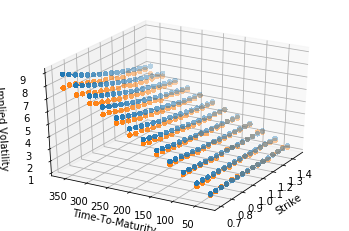

In [73]:
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

ind = 2

_, _, z = feature_extractor.enc.predict(data[ind:ind+1])
rec = feature_extractor.dec.predict(z)

strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

plot_data = {
    "iv_grid_1": data[ind:ind+1],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": rec,
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 0, view_angle=(30, 210))

In [12]:
# save vae
feature_extractor.save_model(f"vae_{test_id}")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/vae_6_enc/assets
INFO:tensorflow:Assets written to: models/vae_6_dec/assets


In [72]:
# load vae
feature_extractor.load_model(f"vae_{test_id}")

In [14]:
# save feature space data
data = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')
print("data shape:",data.shape)
feature_data = feature_extractor.produce_features(data)
print("feature data shape:",feature_data.shape)
feature_extractor.save_produced_features(f"latent_space_data/features_{test_id}")

data shape: (600, 12, 16, 1)
feature data shape: (600, 6)


### Deep Transformer Model for Prediction

In [74]:
# load data and create data set with features
feature_data = np.genfromtxt(f"latent_space_data/features_{test_id}_vae_model", delimiter=',').astype('float32')
print(feature_data.shape)

look_back = 150
num_data_points = feature_data.shape[0]
num_train_data_points = int(0.7*num_data_points)

transformer_model = Transformer_prediction_model(feature_data, params={"look_back": look_back, "forecast_window": int(0.3*num_data_points)})

(600, 6)
Data shape with extra features:  (600, 10)


In [16]:
# train the model
path = "./models/deep_transformer/res/"
best_model = transformer_model.transformer(
    epochs=30, 
    path_to_save_model=path, 
    path_to_save_loss=path, 
    device="cpu"
)

Epoch: 0 , Training Loss: 0.00913020980279736
Epoch: 1 , Training Loss: 0.008079757803886877
Epoch: 2 , Training Loss: 0.00802641376630085
Epoch: 3 , Training Loss: 0.005925623235706342
Epoch: 4 , Training Loss: 0.005014318566952596
Epoch: 5 , Training Loss: 0.004409565369655626
Epoch: 6 , Training Loss: 0.0038295851100378156
Epoch: 7 , Training Loss: 0.0027719339923974323
Epoch: 8 , Training Loss: 0.0021927468850967283
Epoch: 9 , Training Loss: 0.0017728267804144227
Epoch: 10 , Training Loss: 0.0013117691227339625
Epoch: 11 , Training Loss: 0.0010368672327032208
Epoch: 12 , Training Loss: 0.0008389116949710477
Epoch: 13 , Training Loss: 0.0006558239800281831
Epoch: 14 , Training Loss: 0.0005833430831167036
Epoch: 15 , Training Loss: 0.00048102195390710396
Epoch: 16 , Training Loss: 0.0004219562581025619
Epoch: 17 , Training Loss: 0.00037165371776381957
Epoch: 18 , Training Loss: 0.00034771185077816255
Epoch: 19 , Training Loss: 0.00032962770571495244
Epoch: 20 , Training Loss: 0.00029

In [17]:
print(best_model)

best_train_30.pth


In [75]:
# make predictions
prediction_features, in_sample_errors = transformer_model.inference(path_to_save_model="./models/deep_transformer/res/", best_model="best_train_30.pth")
print(prediction_features.shape)

RuntimeError: Error(s) in loading state_dict for Transformer:
	size mismatch for encoder_layer.self_attn.in_proj_weight: copying a param with shape torch.Size([27, 9]) from checkpoint, the shape in current model is torch.Size([30, 10]).
	size mismatch for encoder_layer.self_attn.in_proj_bias: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([30]).
	size mismatch for encoder_layer.self_attn.out_proj.weight: copying a param with shape torch.Size([9, 9]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for encoder_layer.self_attn.out_proj.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for encoder_layer.linear1.weight: copying a param with shape torch.Size([2048, 9]) from checkpoint, the shape in current model is torch.Size([2048, 10]).
	size mismatch for encoder_layer.linear2.weight: copying a param with shape torch.Size([9, 2048]) from checkpoint, the shape in current model is torch.Size([10, 2048]).
	size mismatch for encoder_layer.linear2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for encoder_layer.norm1.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for encoder_layer.norm1.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for encoder_layer.norm2.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for encoder_layer.norm2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([27, 9]) from checkpoint, the shape in current model is torch.Size([30, 10]).
	size mismatch for transformer_encoder.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([30]).
	size mismatch for transformer_encoder.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([9, 9]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for transformer_encoder.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.0.linear1.weight: copying a param with shape torch.Size([2048, 9]) from checkpoint, the shape in current model is torch.Size([2048, 10]).
	size mismatch for transformer_encoder.layers.0.linear2.weight: copying a param with shape torch.Size([9, 2048]) from checkpoint, the shape in current model is torch.Size([10, 2048]).
	size mismatch for transformer_encoder.layers.0.linear2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.0.norm1.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.0.norm1.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.0.norm2.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.0.norm2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.1.self_attn.in_proj_weight: copying a param with shape torch.Size([27, 9]) from checkpoint, the shape in current model is torch.Size([30, 10]).
	size mismatch for transformer_encoder.layers.1.self_attn.in_proj_bias: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([30]).
	size mismatch for transformer_encoder.layers.1.self_attn.out_proj.weight: copying a param with shape torch.Size([9, 9]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for transformer_encoder.layers.1.self_attn.out_proj.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.1.linear1.weight: copying a param with shape torch.Size([2048, 9]) from checkpoint, the shape in current model is torch.Size([2048, 10]).
	size mismatch for transformer_encoder.layers.1.linear2.weight: copying a param with shape torch.Size([9, 2048]) from checkpoint, the shape in current model is torch.Size([10, 2048]).
	size mismatch for transformer_encoder.layers.1.linear2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.1.norm1.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.1.norm1.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.1.norm2.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.1.norm2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.2.self_attn.in_proj_weight: copying a param with shape torch.Size([27, 9]) from checkpoint, the shape in current model is torch.Size([30, 10]).
	size mismatch for transformer_encoder.layers.2.self_attn.in_proj_bias: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([30]).
	size mismatch for transformer_encoder.layers.2.self_attn.out_proj.weight: copying a param with shape torch.Size([9, 9]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for transformer_encoder.layers.2.self_attn.out_proj.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.2.linear1.weight: copying a param with shape torch.Size([2048, 9]) from checkpoint, the shape in current model is torch.Size([2048, 10]).
	size mismatch for transformer_encoder.layers.2.linear2.weight: copying a param with shape torch.Size([9, 2048]) from checkpoint, the shape in current model is torch.Size([10, 2048]).
	size mismatch for transformer_encoder.layers.2.linear2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.2.norm1.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.2.norm1.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.2.norm2.weight: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for transformer_encoder.layers.2.norm2.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for decoder.weight: copying a param with shape torch.Size([5, 9]) from checkpoint, the shape in current model is torch.Size([6, 10]).
	size mismatch for decoder.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([6]).

(180, 6)


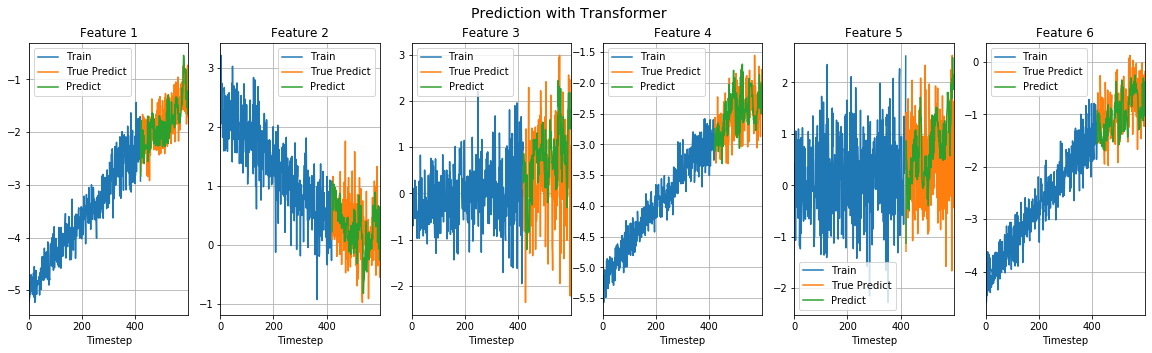

In [27]:
# plot
from feature_prediction.plot.plot_helper_functions import plot_features_with_prediction

true_ = feature_data[num_train_data_points:]

boot_strap_errors = in_sample_errors[np.random.randint(low=220, high=in_sample_errors.shape[0], size=true_.shape[0]),:]
print(boot_strap_errors.shape)
pred_vec = prediction_features#+boot_strap_errors

fig = plot_features_with_prediction(
    data=feature_data[:num_train_data_points],
    prediction=pred_vec,
    true_predictions=true_,
    use_true_predictions=True,
    save_path_and_name=f"prediction_with_transformer_test{test_id}.pdf",
    params={"fig_title":"Prediction with Transformer"}
)

-0.16965520500579334 2.10829199368522 -2.329943323124616


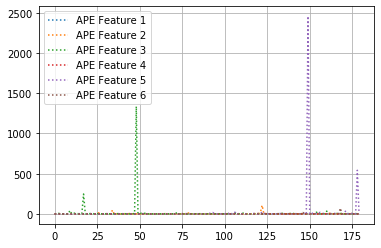

In [29]:
import matplotlib.pyplot as plt

print(np.mean(in_sample_errors),np.max(in_sample_errors),np.min(in_sample_errors))
errors = np.abs((pred_vec - true_) / true_)

x_ = np.arange(0,errors.shape[0])

for i in range(errors.shape[1]):
    reg = np.polyfit(x_, errors[:,i], 1)
    plt.plot(x_, errors[:,i], label=f"APE Feature {i+1}", ls=':')
    #plt.plot(x_, reg[0]*x_+reg[1],  c="black")
    
plt.grid(True)
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim([-0.1, 100])

plt.legend()

### VAE for Predicted IV grids

In [35]:
feature_extractor = Vae_Feature_Extractor(params={"feature_dim":6})
feature_extractor.load_model(f"vae_{test_id}")

In [36]:
predicted_iv_grids = feature_extractor.create_iv_grids_from_features(prediction_features)
print(predicted_iv_grids.shape)

(180, 12, 16, 1)


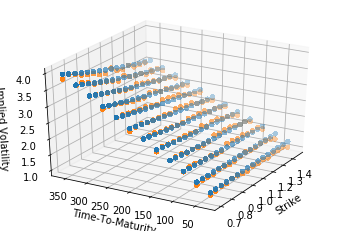

In [66]:
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)


plot_data = {
    "iv_grid_1": data[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 0, view_angle=(30, 210))

Text(0.5, 0, 'Timestep')

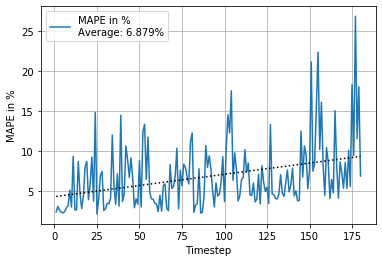

In [67]:
import matplotlib.pyplot as plt

true_ivs = data[600-180:,:,:,0]
predicted_ivs = predicted_iv_grids[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
mean_mape = np.round(np.mean(mape)*1e3)/1e3

x_ = np.arange(1,mape.shape[0]+1)

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
plt.ylabel("MAPE in %")
plt.xlabel("Timestep")



### No-Static-Arbitrage DNN 

In [59]:
# create nsa_ivs_dnn
strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

# same as data above but needs different shape
data_nsa_train = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').astype('float32')

nsa_ivs = NSA_IVS_DNN(data_nsa_train, [strikes, ttms], (3,100,100,100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               19500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               1

In [58]:
# train NSA DNN using training data
nsa_ivs.train()

# save NSA DNN
nsa_ivs.save_model("models/nsa_dnn_model")

Epoch 1/30
60/60 [==============================] - 18s 302ms/step - total_loss: 576.2947 - reconstruction_loss: 576.2453 - nsa_C3: 0.0123 - nsa_C4: 0.0250 - nsa_C5: 0.0123 - nsa_C6: 0.0000e+00
Epoch 2/30
60/60 [==============================] - 18s 296ms/step - total_loss: nan - reconstruction_loss: nan - nsa_C3: nan - nsa_C4: nan - nsa_C5: nan - nsa_C6: 0.0000e+00
Epoch 3/30
60/60 [==============================] - 17s 289ms/step - total_loss: nan - reconstruction_loss: nan - nsa_C3: nan - nsa_C4: nan - nsa_C5: nan - nsa_C6: 0.0000e+00
Epoch 4/30
60/60 [==============================] - 18s 292ms/step - total_loss: nan - reconstruction_loss: nan - nsa_C3: nan - nsa_C4: nan - nsa_C5: nan - nsa_C6: 0.0000e+00
Epoch 5/30
60/60 [==============================] - 20s 333ms/step - total_loss: nan - reconstruction_loss: nan - nsa_C3: nan - nsa_C4: nan - nsa_C5: nan - nsa_C6: 0.0000e+00
Epoch 6/30
60/60 [==============================] - 20s 330ms/step - total_loss: nan - reconstruction_loss

In [60]:
# load NSA DNN
nsa_ivs.load_model("models/nsa_dnn_model")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               19500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 39,801
Trainable params: 39,801
Non-trainable params: 0
_________________________________________________________________


In [61]:
#  create surfaces

strikes_test = np.arange(0.65, 1.55, 0.04)
ttms_test = np.arange(15, 415, 15)

in_sample_nsa_ivs = nsa_ivs.predict_all_surfaces(data_nsa_train, strikes_test, ttms_test)

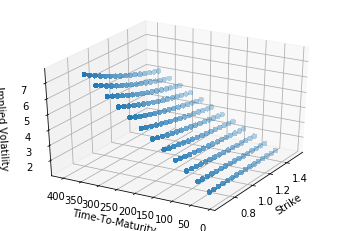

In [63]:
# plot in sample
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)


plot_data = {
    "iv_grid_1": data_nsa_train,
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs,
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 100 , view_angle=(30, 210))


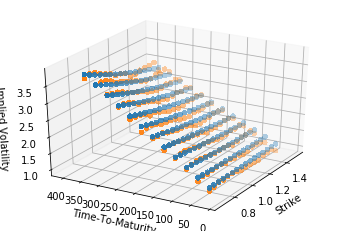

In [65]:
# plot all 
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

nsa_ivs_for_predictions = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes_test, ttms_test)

plot_data = {
    "iv_grid_1": data_nsa_train[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs[600-180:],
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "iv_surface_2": nsa_ivs_for_predictions,
    "stikes_surface_2": strikes_test,
    "ttms_surface_2": ttms_test
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 1, view_angle=(30, 210))


In [5]:
194*30

5820